# Transient Advection-Diffusion
This example will show how to preform a transient advection-diffusion simulation on a 2D Cubic network.

In [1]:
from scipy import special
from scipy.optimize import curve_fit
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)

## Generating Network
A 2D 40 X 40 ``Cubic`` network is generated with a spacing of $10^{-4}$m, but a 3D network would work as well. The geometry, phase, and physics are also defined as follows.

In [2]:
shape = [40, 40, 1]
pn = op.network.Cubic(shape=shape, spacing=1e-4)
geo = op.geometry.SpheresAndCylinders(network=pn, pores=pn.Ps, throats=pn.Ts)
water = op.phases.Water(network=pn)
phys = op.physics.Standard(network=pn, phase=water, geometry=geo)

AttributeError: module 'openpnm' has no attribute 'geometry'

## Defining Effective Pore Volume

The accumulation of mass in the network occurs only in the pores, where the concentration is solved.  In order for mass  accumulate properly, it is necessary to assign the throat volumes to their surrounded throats.  This creates an effective pore volume.  We can define this in a custom pore-scale model, making use of the ``numpy.add.at`` function, to add 1/2 the volume of each throat to its neighboring pores.  

In [3]:
def effective_pore_volume(target, throat_volume='throat.volume', pore_volume='pore.volume'):
    Pvol = geo['pore.volume']
    Tvol = geo['throat.volume']
    Vtot = Pvol.sum() + Tvol.sum()
    np.add.at(Pvol, pn.conns[:, 0], geo['throat.volume']/2)
    np.add.at(Pvol, pn.conns[:, 1], geo['throat.volume']/2)
    assert np.isclose(Pvol.sum(), Vtot)  # Ensure total volume has been added to Pvol
    return Pvol

In [4]:
geo.add_model(propname='pore.effective_volume', model=effective_pore_volume)

NameError: name 'geo' is not defined

## Perform Stokes flow
The advection diffusion algorithm assumes a velocity field. Therefore, Stokes flow in the pore netwok is solved. The ``StokesFlow`` algorthm is solved prior to running the ``AdvectionDiffusion`` algorthim. For more information there is a seperate tutorial on Stokes Flow.

In [5]:
sf = op.algorithms.StokesFlow(network=pn, phase=water,)
sf.set_value_BC(pores=pn.pores('back'), values=50.0)
sf.set_value_BC(pores=pn.pores('front'), values=0)
sf.run();

NameError: name 'water' is not defined

The results obtained from the StokesFlow algorthim must be attached to the water phase.

In [6]:
water.update(sf.results())

NameError: name 'water' is not defined

## Add Diffusive Conductance Model

In [7]:
mod = op.models.physics.ad_dif_conductance.ad_dif
phys.add_model(propname='throat.ad_dif_conductance', model=mod, s_scheme='powerlaw')

NameError: name 'phys' is not defined

## Define Transient Advection Diffusion
An algorthim for transient advection diffusion is defined here. It is assigned to the network and the phase, and will be able to retrieve all information that will be needed.

In [8]:
ad = op.algorithms.TransientAdvectionDiffusion(network=pn, phase=water) 

NameError: name 'water' is not defined

The Dirichlet boundary conditions and the inital conditions are next defined as follows. If the inital condition is not defined then it is assumed to be zero, so it is redundunt in this case. The boundary conditions can be defined as ``value``, ``outflow``, and ``rate``.

In [9]:
inlet  = pn.pores('back') 
outlet = pn.pores('front')
ad.set_value_BC(pores=inlet, values=1.0)
ad.set_outflow_BC(pores=outlet)

NameError: name 'ad' is not defined

## Setup the Transient Algorithim
The settings of the transient algorthim can be updated here. We first define the time span:

In [10]:
tspan = (0, 100)
saveat = 5

We must also tell the algorithm to use the effective pore volume rather than the default which is just 'pore.volume'

In [11]:
ad.settings['pore_volume'] = 'pore.effective_volume'

NameError: name 'ad' is not defined

The algorthim than can be run, but we must pass the initial conditions (could be a scalar or an array), time span, and optionally the intervals at which the solution is desired to be stored.

In [12]:
soln = ad.run(x0=0, tspan=tspan, saveat=saveat)

NameError: name 'ad' is not defined

We can print the algorthims settings as follows:

In [13]:
print(ad.settings)

NameError: name 'ad' is not defined

The solution at eveery time step is stored in the algorthim, and can be printed as follows.

In [14]:
print(ad)

NameError: name 'ad' is not defined

## Visualization using Matplotlib
The pore concentration can be visualized using a 2D heatmap using matplotlib.

NameError: name 'soln' is not defined

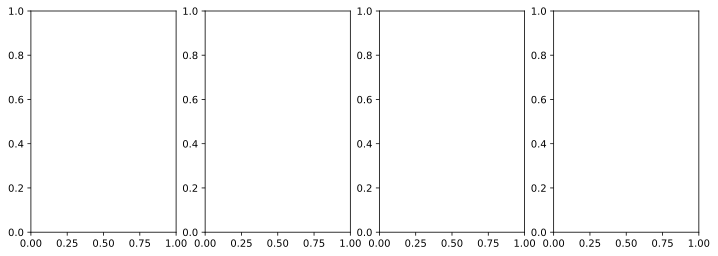

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
t = [10, 20, 30, 40]
for axi, ti in zip(ax, t):
    axi.imshow(soln(ti).reshape(shape))
    axi.set_title(f"t = {ti}")

## Peclet Number

The Peclet number is a dimensionless number defined as the ratio of the rate of advective transport to the rate of diffusive transport. This is often a useful number to know when analyzing advection diffusion problems. It can be calculated using the following equation:

$$Pe_{throat} = \frac{q_{throat}L}{AD_{Ae}}$$

Where $q_{throat}$ is the volumetric flow rate for the throat, $L$ is the length of the throat, $A$ is the cross sectional area of the throat, and $D_{Ae}$ is the diffusion coefficent. A histogram representing the peclet numbers of all throats is presented below as well.

In [16]:
q_throat = sf.rate(throats=pn.Ts, mode='single')
L = pn['throat.length']
A = np.pi/4 * pn['throat.diameter']**2
Pe = q_throat * L / (A * water['throat.diffusivity'])
n, bins, patches = plt.hist(Pe, bins=40, edgecolor='k')
plt.xlabel('Peclet Number')
plt.ylabel('Number of Throats')
plt.title(r'Histogram of Peclet Numbers:')
plt.show()
Pe_avg = Pe.mean()
print(f"Average Peclet Number = {Pe_avg:.2f}")

NameError: name 'sf' is not defined

## Elution Curve

In [17]:
Ps_front = pn.pores(['front'])
Ts_front = pn.find_neighbor_throats(pores=Ps_front, mode='xor')
steps = tspan[1]/saveat + 1
count = 0
c_avg = []

for ti in soln.t:
    c_front = soln(ti)[Ps_front]
    q_front = sf.rate(throats=pn.Ts,mode='single')[Ts_front]
    c_avg.append((q_front*c_front).sum() / q_front.sum())

fig, ax = plt.subplots()    
ax.plot(soln.t, c_avg, "o-")
ax.legend(('simulation', 'fitted'))
ax.set_xlabel('time (s)')
ax.set_ylabel('concentration');

NameError: name 'soln' is not defined

## Solving for the Dispersion Coefficient

The following equation given by Fried (1971) is used to solve the longitudinal dispersion coefficient:

$$\frac{C}{C_{0}} = \frac{1}{2}erfc\Bigl(\frac{x-Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)+\frac{1}{2}exp\Bigl(\frac{Ux}{D_{L}}\Bigl)erfc\Bigr(\frac{x+Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)$$

Where $x$ is the length between the inlet and the outlet, $t$ is the time, $D_{L}$ is the longitudinal dispersion coefficient, $U$ is the average pore velocity, $C_{0}$ is the inlet concentration, and $C$ is the concentration at the given time. Since we defined the inlet concentration as being equal to 1, solving for $C$ is effictivly equal to solving for $\frac{C}{C_{0}}$. ``erfc`` is the complementary error function, which is imported from ``scipy``.



In [18]:
q_throat = sf.rate(throats=pn.Ts, mode='single')
A_throat = pn['throat.cross_sectional_area']
v_throat = q_throat/A_throat
v_pred = sum(q_throat*v_throat)/sum(q_throat)

def elution(step,v,DL):
    x = 40*1e-4
    el1 = 0.5*(special.erfc((x-step*v)/(2*(DL*step)**(1/2))))
    el2 = 0.5*np.exp(v*x/DL)
    el3 = special.erfc((x+step*v)/(2*(DL*step)**(1/2)))
    return el1+el2*el3

NameError: name 'sf' is not defined

In [19]:
g = [v_pred, 1e-3]
xdata = [float(x) for x in soln.t]
ydata = c_avg

popt, pcov = curve_fit(elution, xdata, ydata, p0=g)
disp_coeff = popt[1]
v_fit = popt[0]

print('Dispersion Coefficient = ', "{0:.4E}".format(disp_coeff), ' m^2/s')
print('v_pred = ', "{0:.4E}".format(v_pred), ' m/s')
print('v_fitted = ', "{0:.4E}".format(v_fit), ' m/s')

NameError: name 'v_pred' is not defined

In [20]:
el = np.zeros(len(ydata))
for i in range(len(ydata)):
    el[i] = elution(xdata[i], popt[0], popt[1])

fig, ax = plt.subplots()
ax.plot(xdata, ydata, label="simulation")
ax.plot(xdata, el, ".", label="fitted")
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('concentration');

NameError: name 'ydata' is not defined